# <center> PROJET DE MACHINE LEARNING FOR NLP </center>

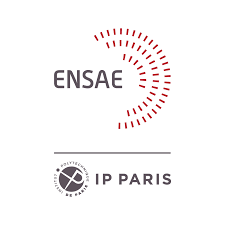

#### <center>  Réalisé par : </center>


<center>ESSOH Lasme Ephrem Dominique (DSSA) </center>
<center>CHABAUD Mathieu (DSSS) </center>
<center>BERREBI Nathan (DSSA)</center>

<br>

<center>Elèves-Ingénieurs 3A (2021 - 2022)</center>




#### <center> Thème :  </center> 

# <center> Analyses textuelles sur Amazon Product Data : analyse de sentiment et génération de texte. </center>


## Modules

Ci-dessous figure la liste des modules utilisés dans le cadre de ce projet. Ces modules sont également stockés dans le fichier d'environnement *requirements.txt*. Pour plus de renseignements, référez-vous au README.md de la page github de ce travail.

Si ce notebook est exécuté sur Google Colab, il sera nécessaire d'installer les modules ci-dessous (dé_commenter les lignes de codes). Il est aussi utile de passer en mode d'éxécution du notebook avec un environnement GPU.

In [1]:
#-------------------------------------
#  POUR COLAB
#-------------------------------------
#!pip install fsspec
#!pip install s3fs
#!pip install botocore
#!pip install boto3
#!pip install transformers

In [2]:
#gestion des exceptions
import warnings
warnings.filterwarnings('ignore')

In [3]:
#gestion des répertoires
import os

#pour le chargement des données depuis notre espace S3 AWS
import boto3

#modules de base pour la science des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#gestion et preprocessing des données textuelles
import string
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

#pour la réalisation des nuages de mots
from wordcloud import WordCloud, STOPWORDS

#pour l'entraînement réseau de neuronnes artificielles pour le sentiment analysis
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer #Tokenizer pour bert
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

#pour la séparation des données afin d'estimer l'erreur de généralisation
from sklearn.model_selection import train_test_split

#pour le calcul de la métrique utilisée pour évaluer le classifieur pour le sentiment analysis
from sklearn.metrics import f1_score

#pour la bar de progression
from tqdm.notebook import tqdm



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lasme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Jeu de données

Pour plus d'informations sur le jeu de données brut que nous utilisons, il faut consulter l'adresse web suivante : https://nijianmo.github.io/amazon/index.html

Le script qui suit récupère automatiquement les données depuis notre espace AWS S3, dans le cas où ils ne sont pas disponible sur votre espace local, et les stocke ensuite. Dans le cas contraire, ce script se contente de juste charger les données en mémoire dans un objet pandas DataFrame nommé df.

In [4]:
url = "s3://nlpensae3a2022/Amazon_Digital_Music.csv" #url de stockage des données dans un espace s3

def fetch_data(dump_url = url):
    """cette fonction récupère automatiquement les données (si besoin)"""
    if not os.path.exists("Raw/Amazon_Digital_Music.csv"):
        if not os.path.isdir("Raw"):
            os.makedirs("Raw")
        print("Chargement des données en cours, patientez encore ...")
        print("===============================================================")
        client = boto3.client("s3")
        df = pd.read_csv(dump_url)
        print("...")
        print("...")
        print("...")
        df.to_csv("Raw/Amazon_Digital_Music.csv", index=False)
        print("Chargement terminé !")
        return df
        
    else:
        return pd.read_csv("Raw/Amazon_Digital_Music.csv")

Récupération des données : 

In [5]:
df = fetch_data()

Liste des colonnes et leurs types :

In [6]:
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
dtype: object

Premières lignes du jeu de données brut : 

In [7]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"12 22, 2013",A1ZCPG3D3HGRSS,0001388703,{'Format:': ' Audio CD'},mark l. massey,This is a great cd full of worship favorites!!...,Great worship cd,1387670400,NaN,NaN
1,5.0,True,"09 11, 2013",AC2PL52NKPL29,0001388703,{'Format:': ' Audio CD'},Norma Mushen,"So creative! Love his music - the words, the ...",Gotta listen to this!,1378857600,NaN,NaN
2,5.0,True,"03 2, 2013",A1SUZXBDZSDQ3A,0001388703,{'Format:': ' Audio CD'},Herbert W. Shurley,"Keith Green, gone far to early in his carreer,...",Great approach still gets the message out,1362182400,NaN,NaN
3,5.0,True,"12 2, 2012",A3A0W7FZXM0IZW,0001388703,{'Format:': ' Audio CD'},Mary M Raybell,Keith Green had his special comedy style of Ch...,Great A must have,1354406400,NaN,NaN
4,5.0,False,"01 7, 2012",A12R54MKO17TW0,0001388703,{'Format:': ' Audio CD'},J. Bynum,Keith Green / So you wanna go back to Egypt......,A great one from Keith with a guest appearance...,1325894400,6.0,NaN


Taille du jeu de données brut : 

In [8]:
df.shape

(1584082, 12)

Dans ce travail, nous traitons de plus de 1 millions d'avis de consommateurs sur des produits de la categorie Digital Music achetés depuis le site de vente ligne Amazon (US). Il y a en tout 12 colonnes mesurant diverses informations sur ces avis, nous intéressons principalement au commentaire refletant les avis des consommateurs ainsi que leur évaluation sur une échelle de 1 à 5 

Dans ce qui suit, nous présentons une prétraitement ainsi qu'une analyse exploratoire des données sur les 1,5 millions d'avis. Certains prétraitement peuvent mettre du temps à se finaliser à cause de la taille relativement importante du jeu de données.

## Preprocessing des données

Nous commençons par prétraités les colonnes ensuite nous nous attaquons aux données textuelles. 

* Traitement des colonnes :

Etant donné que les notes sont regroupées de 0 à 5, nous nous proposons de les regrouper en classe de trois : négatif, neutre et positif. On définit la fonction suivante :

In [9]:
def classify(x):
    if x == 5.0 or x == 4.0:
        return 2 #positif
    if x == 3.0:
        return 1 #neutre
    return 0 #négatif

df["y"] = df["overall"].apply(classify)

Supprimons ensuite les colonnes qui ne nous seront pas utiles : 

In [10]:
df = df.drop(labels = ["verified", "reviewerID", "asin" ,"style","reviewerName", "unixReviewTime","vote", "image"],axis = 1)
df.head()

,overall,reviewTime,reviewText,summary,y
0,5.0,"12 22, 2013",This is a great cd full of worship favorites!!...,Great worship cd,2
1,5.0,"09 11, 2013","So creative! Love his music - the words, the ...",Gotta listen to this!,2
2,5.0,"03 2, 2013","Keith Green, gone far to early in his carreer,...",Great approach still gets the message out,2
3,5.0,"12 2, 2012",Keith Green had his special comedy style of Ch...,Great A must have,2
4,5.0,"01 7, 2012",Keith Green / So you wanna go back to Egypt......,A great one from Keith with a guest appearance...,2


* Traitement des commentaires : 

Supprimons toutes les ponctuations  des textes décrivant les commentaires de produits "reviewText". Il s'agit des caractères suivants :  *!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~. Nous réalisons cette suppression avec la module string et son attribut ponctuation : string.ponctuation en définissant la fonction suivante :            

In [11]:
def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct =''.join(no_punct)
    return words_wo_punct

df["reviewText"] = df["reviewText"].astype(str)
df["reviewText"] = df["reviewText"].apply(lambda x: remove_punctuation(x.lower()))

Procédons ensuite à d'autres traitements de textes : la racinisation des mots employés (pour rappel, c'est le processus qui consiste ramener un mot à sa racine. Nous utilisons ici la racinisation à algorithme de Porter), l'élimination des stopwords et la gestion des expressions régulières :

In [12]:
def text_process(df):
    # racinisation
    stemmer = PorterStemmer()
    # élimination des stop words anglais comme "the, I, our etc"
    words = stopwords.words("english") 
    df['cleaned_reviews'] = df['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
    print("Prétraitement des données en cours, patientez encore ...")
    print("===============================================================")
    print("...")
    print("...")
    print("...")
    df.to_csv("Raw/Amazon_Digital_Music_Cleaned.csv", index = False)
    print("Prétraitement terminé !")
    return df

df = text_process(df)

Prétraitement des données en cours, patientez encore ...
...
...
...
Prétraitement terminé !


Premières lignes des données prétraitées : 

In [13]:
df.head()

,overall,reviewTime,reviewText,summary,y,cleaned_reviews
0,5.0,"12 22, 2013",this is a great cd full of worship favorites ...,Great worship cd,2,great cd full worship favorit time great keith...
1,5.0,"09 11, 2013",so creative love his music the words the mes...,Gotta listen to this!,2,creativ love music word messag favorit song cd...
2,5.0,"03 2, 2013",keith green gone far to early in his carreer l...,Great approach still gets the message out,2,keith green gone far earli carreer left us gol...
3,5.0,"12 2, 2012",keith green had his special comedy style of ch...,Great A must have,2,keith green special comedi style chirstian mus...
4,5.0,"01 7, 2012",keith green so you wanna go back to egypt in...,A great one from Keith with a guest appearance...,2,keith green wanna go back egypt album keith ge...


## Analyse exploratoire des données

Il s'agit de présenter dans cette section une analyse descriptive des avis des consommateurs relativement aux produits qu'ils ont achetés.

### Distributions des sentiments

In [14]:
#transformons d'abors les encodages numériques en étiquettes nominales
df["classes"] = df["overall"]
df["classes"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
df["classes"].unique()

# Supprimons aussi les lignes sans commentaires
df = df.dropna(subset=['cleaned_reviews'])

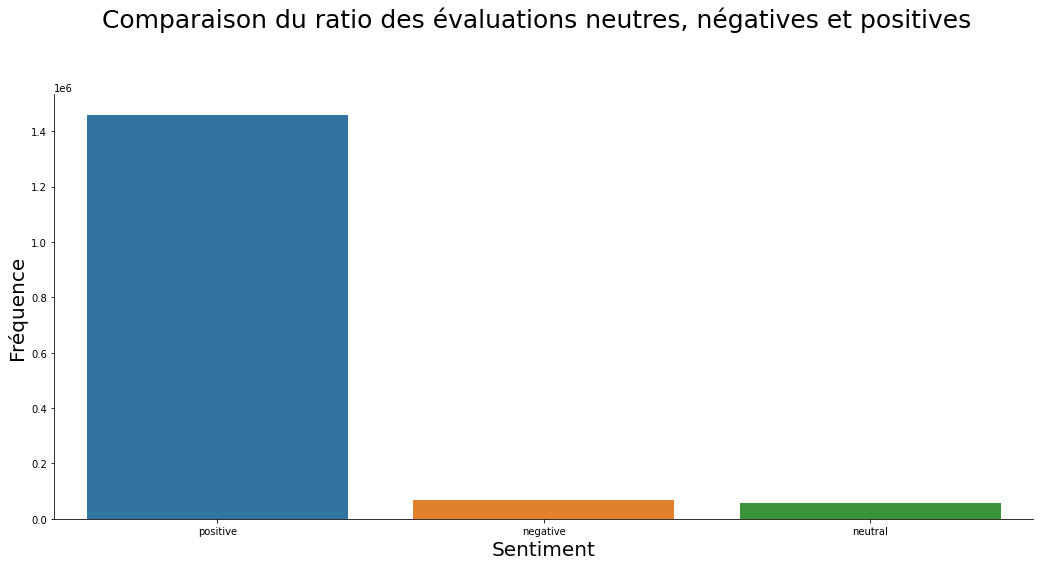

In [15]:
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparaison du ratio des évaluations neutres, négatives et positives", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "classes", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Fréquence", fontsize = 20)
sns.despine()

Les évaluations sont majoritairements positives, le jeu de données est déséquilibré !
Ci-dessous figure une description des proportions de chaque sentiment : négatif, neutre et positif.

In [16]:
def pert_count(data, category):
    return (len(data[data["classes"] == category])/len(data)) * 100
print(f"Pourcentage de mots \"neutre\" --> {pert_count(df, 'neutral')} %")
print(f"Pourcentage de mots \"negatif\"  --> {pert_count(df, 'negative')} %")
print(f"Pourcentage de mots \"positif\" --> {pert_count(df, 'positive')} %")

Pourcentage de mots "neutre" --> 3.620204004590671 %
Pourcentage de mots "negatif"  --> 4.208052360925761 %
Pourcentage de mots "positif" --> 92.17174363448358 %


### Nuage de mots

Nous définissons la fonction ci-dessous pour réaliser un nuage des mots usuels :

In [17]:
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5, 7.5))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.25)
    plt.imshow(wordcloud)
    plt.show()
    print("\n")

Réprésentons les nuages de mots les plus usuels en fonction des avis :

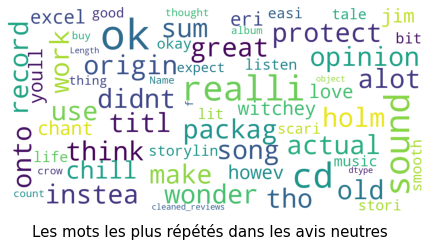

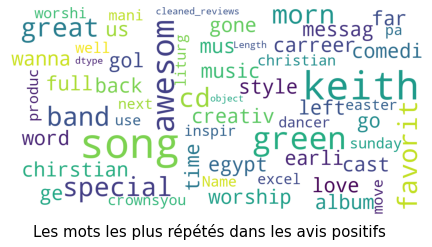

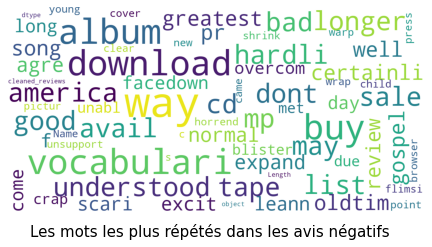

In [18]:
neu=df[df["classes"] == "neutral"]["cleaned_reviews"]
neg=df[df["classes"] == "negative"]["cleaned_reviews"]
pos=df[df["classes"] == "positive"]["cleaned_reviews"]
word_cloud(neu, "Les mots les plus répétés dans les avis neutres")
word_cloud(pos, "Les mots les plus répétés dans les avis positifs")
word_cloud(neg, "Les mots les plus répétés dans les avis négatifs")

### Expressions les plus fréquentes dans le jeu de données

Nous présentons des bigrammes à partir des avis des consommateurs.

In [19]:
#création des bigrammes
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#tracés des bigrammes
def n_gram_plot(data,title,color):
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y,x,color='{}'.format(color))
    plt.title('Commentaire {} (Bigramme)'.format(title),fontsize=10)
    plt.yticks(rotation=0,fontsize=15)

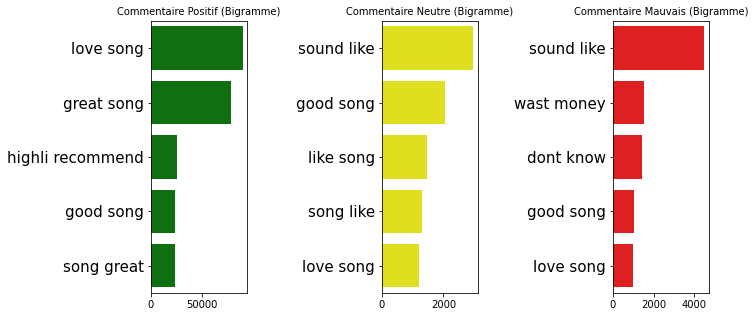

In [20]:
common_words_good = get_top_n_bigram(pos, 5)
common_words_neutral= get_top_n_bigram(neu, 5)
common_words_bad= get_top_n_bigram(neg, 5)

plt.figure(figsize=(10,5))

#top 5 bigrammes des avis positifs
plt.subplot(151)
n_gram_plot(common_words_good,'Positif','green')
#============================================= 
#top 5 bigrammes des avis neutres
plt.subplot(153)
n_gram_plot(common_words_neutral,'Neutre','yellow')
#============================================= 
#top 5 bigrammes des avis négatifs
plt.subplot(155)
n_gram_plot(common_words_bad,'Mauvais','red')
plt.show()

On peut voir que les commentaires postifs et négatifs sont très proches.

# Analyse de sentiments

Dans cette section, nous menons une analyse de sentiment les avis des consommateurs. Le but est de prédire le type de commentaire (positif, neutre ou négatif) par le texte du commentaire. Nous commençons par entraîner un modèle LSTM classique. Ce modèle est considéré par la suite comme un benchmark. Nous entraînons dans un second temps un modèle pré-entraîné connu pour ses bonnes performances pour l'analyse de sentiment, BERT (Google, 2015).

In [21]:
#chargeons le jeu de données prétraitées
df = pd.read_csv("Raw/Amazon_Digital_Music_Cleaned.csv")

La taille du jeu de données est relativement importante ainsi l'entrainement des modèle peut prendre du temps. Nous vous recommandons de choisir une taille raisonnable pour une obtention rapide des résultats, cependant rien ne vous empêche de choisir la taille maximale du jeu de données. Par exemple, sur notre espace local de travail avec un GPU RTX 2060, nous mettons environs 23 heures de temps pour entrainer BERT sur toutes les observations et 3h pour 100 000 observations. Le temps est encore réduit pour 20 000 observations. 

*NB : Notre GPU étant plus réçent que celui mis à disposition par Google Colab non Pro, nos exécutions sont encore plus rapides en local que sur Colab, ainsi il faudra choisir une taille raisonnable pour l'exécution sur Colab, par exemple 10 000, 20 000 ou 50 000 pour aller vite. Néanmoins nous avons faire nos tests avec 100 000 observations sur Colab.*

### LSTM

Développons, à présent, notre modélisation LSTM pour l'analyse de sentiment.

L'analyse des bigrammes et des nuages de points révèle que les deux classes : neutres et négatifs sont plutôt très proches. Nous nous proposons de les rassembler avant d'appliquer notre modèle LSTM.

In [22]:
def classify(x):
    if x == 0 or x == 1:
        return 0 #négatif
    return 1 #positif

df["y"] = df["y"].apply(classify)
df["y"].value_counts()

1    1460076
0     124006
Name: y, dtype: int64

Comme le jeu de données est déséquilibré, nous le réquilibrons avant entrainement du LSTM en prenant, de part et d'autres, la moitié comme taille des données échantillonnées pour la classe des négatifs et des positifs.

In [23]:
n_sample = 20000
df_negatives = df[df.y == 0].sample(n = int(n_sample/2) , random_state=1)
df_positives = df[df.y == 1].sample(n = int(n_sample/2) , random_state=1)
df_balanced = pd.concat([df_negatives, df_positives])
df_balanced.value_counts('y')

y
0    10000
1    10000
dtype: int64

Nous créons ensuite un vocabulaire associant un nombre à chaque mot de notre corpus. Pour cela, nous rassemblons tous les mots présents dans une liste, puis nous créons un dictionnaire associant chaque mot à un index (en ajoutant "pad" pour les fins de phrase et "unk" pour les mots qui n'apparaissent pas dans le corpus).

In [24]:
df_balanced["cleaned_reviews"] = df_balanced["cleaned_reviews"].astype("str")
all_words = [w for s in df_balanced.cleaned_reviews.values.tolist() for w in s.split()]
words = Counter(all_words)
words = {k:v for k,v in words.items() if v > 1}
words = sorted(words, key = words.get, reverse = True)
words = ['_PAD', '_UNK'] + words

Porcédons au padding des données : 

In [25]:
word_to_idx = { w : i for i,w in enumerate(words) }
idx_to_word = {v : k for k,v in word_to_idx.items()}

def process_sequence(text_sequence):
    global word_to_idx
    res = []
    for w in text_sequence:
        if w in word_to_idx:
            res.append(word_to_idx[w])
        else:
            res.append(1)
    return res

X = [process_sequence(s.split()) for s in df_balanced.cleaned_reviews.values.tolist()]
y = df_balanced.y.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#padding des données
MAX_LEN = max([len(s) for s in  X_train])
X_train = pad_sequences(X_train, maxlen = MAX_LEN, padding = 'pre')
X_test = pad_sequences(X_test, maxlen = MAX_LEN, padding = 'pre')
y_train = np.array(y_train)
y_test = np.array(y_test)

Entrainons à présent notre LSTM pour l'analyse de sentiments :

In [26]:
#formattage des données train et test pour pytorch
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

###taille du batch
batch_size = 32 #gérer la taille du batch en fonction de ses capacités GPU, chez le max c'est 32 pour cette architecture

train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle = True, batch_size = batch_size, drop_last = True)

In [27]:
#architecture du réseau de neurones
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first = True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size) # fully connected
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long() # cast to long tensor
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [29]:
#Tester la presence d'un GPU
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [30]:
vocab_size = len(word_to_idx) + 1
output_size = 1
embedding_dim = 400 #essayer aussi 128 ou 256
hidden_dim = 512 #essayer aussi 256
n_layers = 2

model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(13688, 400)
  (lstm): LSTM(400, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [31]:
#taux d'apprentissage fixe et optimiseur Adam
lr = 0.005
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [32]:
#entrainement du LSTM
epochs = 1
counter = 0
print_every = 50
clip = 5
test_loss_min = np.Inf

model.train()

for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([e.data for e in h])
        model.zero_grad()  
        output, h = model(inputs, h) 
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            test_h = model.init_hidden(batch_size)
            test_losses = []
            num_correct = 0
            model.eval()
            for inp, lab in test_loader:
                test_h = tuple([each.data for each in test_h])
                inp, lab = inp.to(device), lab.to(device)
                out, test_h = model(inp, test_h)
                test_loss = criterion(out.squeeze(), lab.float())
                test_losses.append(test_loss.item())
                
                pred = torch.round(out.squeeze())
                correct_tensor = pred.eq(lab.float().view_as(pred))
                correct = np.squeeze(correct_tensor.cpu().numpy())
                num_correct += np.sum(correct) # sums matches

            print("Test loss: {:.3f}".format(np.mean(test_losses)))
            test_acc = num_correct/len(test_loader.dataset)
            print("Test accuracy: {:.3f}%".format(test_acc*100))

                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Test Loss: {:.6f}".format(np.mean(test_losses)))
            if np.mean(test_losses) <= test_loss_min:
                torch.save(model.state_dict(), 'best_LSTM_model.pt')
                print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min, np.mean(test_losses)))
                test_loss_min = np.mean(test_losses)

Test loss: 0.562
Test accuracy: 71.360%
Epoch: 1/1... Step: 50... Loss: 0.380937... Test Loss: 0.561648
Test loss decreased (inf --> 0.561648).  Saving model ...
Test loss: 0.545
Test accuracy: 72.440%
Epoch: 1/1... Step: 100... Loss: 0.483072... Test Loss: 0.545286
Test loss decreased (0.561648 --> 0.545286).  Saving model ...
Test loss: 0.495
Test accuracy: 75.220%
Epoch: 1/1... Step: 150... Loss: 0.494641... Test Loss: 0.495345
Test loss decreased (0.545286 --> 0.495345).  Saving model ...
Test loss: 0.473
Test accuracy: 78.160%
Epoch: 1/1... Step: 200... Loss: 0.545571... Test Loss: 0.473401
Test loss decreased (0.495345 --> 0.473401).  Saving model ...
Test loss: 0.468
Test accuracy: 79.320%
Epoch: 1/1... Step: 250... Loss: 0.503684... Test Loss: 0.467628
Test loss decreased (0.473401 --> 0.467628).  Saving model ...
Test loss: 0.449
Test accuracy: 79.160%
Epoch: 1/1... Step: 300... Loss: 0.443184... Test Loss: 0.448914
Test loss decreased (0.467628 --> 0.448914).  Saving model ..

### BERT

In [33]:
#chargeons le jeu de données prétraitées
df = pd.read_csv("Raw/Amazon_Digital_Music_Cleaned.csv")

In [34]:
#échantillonnage pour l'éxécution rapide
#n_sample = 20000
#print("Distribution du target avant échantillonnage : ")
#print(df["y"].value_counts(normalize = "True")*100)
#df = df.sample(n=n_sample, weights='overall', random_state=1).reset_index(drop=True)
#print("Distribution du target après échantillonnage : ")
#print(df["y"].value_counts(normalize = "True")*100)
#print("""On veille à plus ou moins (quelques écarts après tirages) conserver les distributions du target dans l'échantillonnage !""")

In [35]:
n_sample = 20000
df_negatives = df[df.y == 0].sample(n = int(n_sample/3) , random_state=1)
df_neutres = df[df.y == 1].sample(n = int(n_sample/3) , random_state=1)
df_positives = df[df.y == 2].sample(n = int(n_sample/3) , random_state=1)
df_balanced = pd.concat([df_negatives, df_neutres, df_positives])
df_balanced.value_counts('y')

y
0    6666
1    6666
2    6666
dtype: int64

In [36]:
#Création d'un dictionnaire qui contient tous les claases uniques de y
df = df_balanced
possible_labels = df.y.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = int(possible_label)
label_dict

{0: 0, 1: 1, 2: 2}

In [37]:
#renommage de y en label
df['label'] = [label_dict[str_label] for str_label in df['y']]

In [38]:
#sépartion du jeu de données en données d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.40, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

#création d'une colonne data_type pour indiquer si chaque instance est dans le val ou le train
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['y', 'label', 'data_type']).count()

overall  reviewTime  reviewText  summary  cleaned_reviews
y label data_type                                                           
0 0     train         4000        4000        3998     3998             3989
        val           2666        2666        2666     2666             2662
1 1     train         3999        3999        3999     3998             3990
        val           2667        2667        2666     2667             2662
2 2     train         3999        3999        3995     3998             3986
        val           2667        2667        2663     2667             2661

In [39]:
#initialisation du tokenizer pour BERT
df['reviewText'] = df['reviewText'].astype("str")
df["cleaned_reviews"] = df["cleaned_reviews"].astype("str")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)              
#encodage du batch pour le train                           
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
#Encodage du batch pour le val                         
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

#extraction de variables des objets encodés pour un usage simple
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

#création des tenseurs
labels_val = torch.tensor(df[df.data_type=='val'].label.values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [40]:
#initialisation du BERT pour la classification de séquences
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [41]:
batch_size = 1
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [42]:
#usage de l'optimiseur ADAM
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
#définissions du nombre d'epochs
epochs = 2

#échéancier d'apprentissage gerer le dynamique du taux d'apprentissage
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [43]:
#calcul de la f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

#calcul de l'accuracy par classe de notation (negatif, neutre, positif)
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    correct=0
    total=0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        correct+=len(y_preds[y_preds==label])
        total+=len(y_true)
    print(f'Bert Model Accuracy Overall :',correct/total)

In [44]:
#verification de la présence d'un GPU. Sinon utilisation d'un CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu")
model.to(device)
print(device)

cuda


In [45]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Fonction Evaluate utilisée avec tqdm pour afficher la progression en live de l'apprentissage du modèle
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
  
#Entrainement du modèle
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
      
    # Ecriture des résultats  
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    #Sauvegarde du modèle finetuned par epoch
    torch.save(model.state_dict(), 'BERT_final.pt')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/11998 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2391232132485162
Validation loss: 1.1567947702319508
F1 Score (Weighted): 0.7421149579262083


Epoch 2:   0%|          | 0/11998 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8947260145048612
Validation loss: 1.295314669850617
F1 Score (Weighted): 0.7573075648075585


In [46]:
#Affichage des accuracy par classe de label
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 2039/2666

Class: 1
Accuracy: 1750/2667

Class: 2
Accuracy: 2276/2667

Bert Model Accuracy Overall : 0.758125


## Generation des summary